In [25]:
#importing packages
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
import pandas_datareader as pdr
import seaborn as sns
import matplotlib.pyplot as plt
import bs4 as bs
import requests
from IPython.display import clear_output
from scipy.stats import mstats
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import RandomizedSearchCV, validation_curve, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle
import os
from sklearn.model_selection import GridSearchCV
import yfinance as yf
import json
import time
sns.set()

In [2]:

#Obtain list of S&100 companies from wikipedia
resp = requests.get("https://en.wikipedia.org/wiki/S%26P_100")
convert_soup = bs.BeautifulSoup(resp.text, 'lxml')
table = convert_soup.find('table',{'class':'wikitable sortable'})

tickers = []

for rows in table.findAll('tr')[1:]:
    ticker = rows.findAll('td')[0].text.strip()
    tickers.append(ticker)
tickers = ["BRK-B" if i == "BRK.B" else i for i in tickers]

In [3]:
ticker_to_sector = {}
for ticker in tickers:
    print(ticker)
    try:
        sector = yf.Ticker(ticker).info['sector']
        print(sector)
        ticker_to_sector[ticker] = sector
        clear_output(wait = True)
    except:
        ticker_to_sector[ticker] = 'Misc'
    clear_output(wait = True)

ticker_to_sector

{'AAPL': 'Technology',
 'ABBV': 'Healthcare',
 'ABT': 'Healthcare',
 'ACN': 'Technology',
 'ADBE': 'Technology',
 'AIG': 'Financial Services',
 'AMGN': 'Healthcare',
 'AMT': 'Real Estate',
 'AMZN': 'Consumer Cyclical',
 'AVGO': 'Technology',
 'AXP': 'Financial Services',
 'BA': 'Industrials',
 'BAC': 'Financial Services',
 'BIIB': 'Healthcare',
 'BK': 'Financial Services',
 'BKNG': 'Consumer Cyclical',
 'BLK': 'Financial Services',
 'BMY': 'Healthcare',
 'BRK-B': 'Financial Services',
 'C': 'Financial Services',
 'CAT': 'Industrials',
 'CHTR': 'Communication Services',
 'CL': 'Consumer Defensive',
 'CMCSA': 'Communication Services',
 'COF': 'Financial Services',
 'COP': 'Energy',
 'COST': 'Consumer Defensive',
 'CRM': 'Technology',
 'CSCO': 'Technology',
 'CVS': 'Healthcare',
 'CVX': 'Energy',
 'DD': 'Basic Materials',
 'DHR': 'Healthcare',
 'DIS': 'Communication Services',
 'DOW': 'Basic Materials',
 'DUK': 'Utilities',
 'EMR': 'Industrials',
 'EXC': 'Utilities',
 'F': 'Consumer Cycli

In [4]:
# AlphaVantage API key
av_api_key = '5VQ508GPQ4POSK3F'

def get_url(url):
    """ simple function to access the url
    gets the html data from the given url
    
    Args:
        url (String): the url to request data from
        
    Returns:
        html_str (String): the html response from the url
    """
    # Get response from request url
    response = requests.get(url)
    
    # Return html string
    html_res = response.json()
    return html_res

url=f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&interval=5min&symbol=IBM&apikey={av_api_key}'
#get_url(url)

def construct_and_get_query(func, feats):
    '''Given a dict of desired features and the function, builds a query
    to access the AlphaVantage API to get the html data
    
    Args:
        func (string): the desired function of the query
        feats (dict): a dict of the desired features and values
        
    Returns:
        html_str (string): the html response from the url
    '''
    # Base url for every query
    url = f'https://www.alphavantage.co/query?function={func}'
    
    # Add every feature and value to query
    for feat, value in feats.items():
        url += f'&{feat}={value}'
    
    # Add API key
    url += f'&apikey={av_api_key}'

    # Get the html data from the url
    return get_url(url)

In [5]:
all_data = pd.DataFrame()
test_data = pd.DataFrame()
no_data = []

#Extract data from Yahoo Finance
for i in tickers:
    try:
        print(i)
        test_data = pdr.get_data_yahoo(i, start = dt.datetime(2000,1,1), end = (dt.date.today() - timedelta(days=1)))
        test_data['Symbol'] = i
        all_data = all_data.append(test_data)
        clear_output(wait = True)
    except:
        no_data.append(i)

    clear_output(wait = True)

In [6]:
all_data

,High,Low,Open,Close,Volume,Adj Close,Symbol
Date,,,,,,,
2000-01-03,1.004464,0.907924,0.936384,0.999442,535796800.0,0.856227,AAPL
2000-01-04,0.987723,0.903460,0.966518,0.915179,512377600.0,0.784038,AAPL
2000-01-05,0.987165,0.919643,0.926339,0.928571,778321600.0,0.795511,AAPL
2000-01-06,0.955357,0.848214,0.947545,0.848214,767972800.0,0.726669,AAPL
2000-01-07,0.901786,0.852679,0.861607,0.888393,460734400.0,0.761090,AAPL
...,...,...,...,...,...,...,...
2021-04-23,55.939999,55.180000,55.270000,55.570000,15337900.0,55.570000,XOM
2021-04-26,56.290001,55.439999,55.470001,55.680000,16083800.0,55.680000,XOM
2021-04-27,56.630001,55.810001,56.009998,56.410000,19278600.0,56.410000,XOM


In [7]:
all_data['Sector'] = all_data.apply(lambda row: ticker_to_sector[row['Symbol']], axis=1)

In [8]:
all_data

,High,Low,Open,Close,Volume,Adj Close,Symbol,Sector
Date,,,,,,,,
2000-01-03,1.004464,0.907924,0.936384,0.999442,535796800.0,0.856227,AAPL,Technology
2000-01-04,0.987723,0.903460,0.966518,0.915179,512377600.0,0.784038,AAPL,Technology
2000-01-05,0.987165,0.919643,0.926339,0.928571,778321600.0,0.795511,AAPL,Technology
2000-01-06,0.955357,0.848214,0.947545,0.848214,767972800.0,0.726669,AAPL,Technology
2000-01-07,0.901786,0.852679,0.861607,0.888393,460734400.0,0.761090,AAPL,Technology
...,...,...,...,...,...,...,...,...
2021-04-23,55.939999,55.180000,55.270000,55.570000,15337900.0,55.570000,XOM,Energy
2021-04-26,56.290001,55.439999,55.470001,55.680000,16083800.0,55.680000,XOM,Energy
2021-04-27,56.630001,55.810001,56.009998,56.410000,19278600.0,56.410000,XOM,Energy


In [9]:
all_data['Close'].pct_change()

Date
2000-01-03         NaN
2000-01-04   -0.084310
2000-01-05    0.014634
2000-01-06   -0.086538
2000-01-07    0.047368
                ...   
2021-04-23    0.005428
2021-04-26    0.001979
2021-04-27    0.013111
2021-04-28    0.030137
2021-04-29    0.014283
Name: Close, Length: 500125, dtype: float64

In [10]:
def get_tech_ind(ticker, indicators, num_days):
    '''
    '''
    ti_dict = {}
    i = 0
    for indicator in indicators:
        if i == 5:
            time.sleep(60)
            i = 0
        url = f'https://www.alphavantage.co/query?function={indicator}&symbol={ticker}&interval=daily&time_period={num_days}&series_type=close&apikey={av_api_key}&datatype=json'
        ti_dict[indicator] = requests.get(url).json()
        i += 1
        
    return ti_dict 

In [11]:
all_data

,High,Low,Open,Close,Volume,Adj Close,Symbol,Sector
Date,,,,,,,,
2000-01-03,1.004464,0.907924,0.936384,0.999442,535796800.0,0.856227,AAPL,Technology
2000-01-04,0.987723,0.903460,0.966518,0.915179,512377600.0,0.784038,AAPL,Technology
2000-01-05,0.987165,0.919643,0.926339,0.928571,778321600.0,0.795511,AAPL,Technology
2000-01-06,0.955357,0.848214,0.947545,0.848214,767972800.0,0.726669,AAPL,Technology
2000-01-07,0.901786,0.852679,0.861607,0.888393,460734400.0,0.761090,AAPL,Technology
...,...,...,...,...,...,...,...,...
2021-04-23,55.939999,55.180000,55.270000,55.570000,15337900.0,55.570000,XOM,Energy
2021-04-26,56.290001,55.439999,55.470001,55.680000,16083800.0,55.680000,XOM,Energy
2021-04-27,56.630001,55.810001,56.009998,56.410000,19278600.0,56.410000,XOM,Energy


In [110]:
# Setting a new data frame used for random forest classifier
rfc_data = all_data.copy()

In [111]:
rfc_data

,High,Low,Open,Close,Volume,Adj Close,Symbol,Sector
Date,,,,,,,,
2000-01-03,1.004464,0.907924,0.936384,0.999442,535796800.0,0.856227,AAPL,Technology
2000-01-04,0.987723,0.903460,0.966518,0.915179,512377600.0,0.784038,AAPL,Technology
2000-01-05,0.987165,0.919643,0.926339,0.928571,778321600.0,0.795511,AAPL,Technology
2000-01-06,0.955357,0.848214,0.947545,0.848214,767972800.0,0.726669,AAPL,Technology
2000-01-07,0.901786,0.852679,0.861607,0.888393,460734400.0,0.761090,AAPL,Technology
...,...,...,...,...,...,...,...,...
2021-04-23,55.939999,55.180000,55.270000,55.570000,15337900.0,55.570000,XOM,Energy
2021-04-26,56.290001,55.439999,55.470001,55.680000,16083800.0,55.680000,XOM,Energy
2021-04-27,56.630001,55.810001,56.009998,56.410000,19278600.0,56.410000,XOM,Energy


In [112]:
def set_target_var(rfc_data, num_days):
    """
    """
    future_name = "Close_Future_" + str((num_days - 1))
    rfc_data[future_name] = rfc_data.groupby('Symbol')['Close'].transform(
        lambda x: x.shift(-(num_days - 1)))
    print('Done')
    rfc_data['Target'] = ((rfc_data[future_name] - rfc_data['Open'])/(rfc_data['Open']) * 100).shift(-1)
    rfc_data['Target_Direction'] = np.where(rfc_data['Target']>0,1,0)
    print('Done')
    rfc_data = rfc_data.dropna().copy()
    clear_output(wait = True)
    return rfc_data

In [113]:
rfc_data = set_target_var(rfc_data, 14)

Done
Done


In [114]:
rfc_data

,High,Low,Open,Close,Volume,Adj Close,Symbol,Sector,Close_Future_13,Target,Target_Direction
Date,,,,,,,,,,,
2000-01-03,1.004464,0.907924,0.936384,0.999442,535796800.0,0.856227,AAPL,Technology,0.993862,-1.847574,0
2000-01-04,0.987723,0.903460,0.966518,0.915179,512377600.0,0.784038,AAPL,Technology,0.948661,8.192779,1
2000-01-05,0.987165,0.919643,0.926339,0.928571,778321600.0,0.795511,AAPL,Technology,1.002232,3.828036,1
2000-01-06,0.955357,0.848214,0.947545,0.848214,767972800.0,0.726669,AAPL,Technology,0.983817,13.989639,1
2000-01-07,0.901786,0.852679,0.861607,0.888393,460734400.0,0.761090,AAPL,Technology,0.982143,-0.367642,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-05,57.320000,56.139999,57.299999,56.500000,23264800.0,56.500000,XOM,Energy,55.270000,-2.234343,0
2021-04-06,57.540001,56.259998,56.840000,56.340000,18926300.0,56.340000,XOM,Energy,55.570000,-1.259087,0
2021-04-07,56.770000,56.240002,56.389999,56.590000,22385000.0,56.590000,XOM,Energy,55.680000,0.858215,1


In [115]:
indicators = ['SMA', 'EMA', 'MACD', 'STOCH', 'RSI', 'ADX', 'CCI', 'AROON', 'BBANDS', 'OBV', 'ATR', 'ROC']

In [116]:
tickers_to_go = ['BRK-B']

In [117]:
def get_indicator_data(num_days):
    i = 1
    output_dict = {}
    no_data = {}
    time.sleep(60)
    for ticker in tickers_to_go:
        indicator_list = []
        no_data_list = []
        for indicator in indicators:
            if i == 5:
                time.sleep(60)
                i = 1
            indicator_data = get_tech_ind(ticker, [indicator], num_days)
            if 'Information' in indicator_data[indicator].keys():
                no_data_list.append(indicator)
                print(ticker + ' - API Request Error')
            indicator_list.append(indicator_data)
            i += 1
        output_dict[ticker] = indicator_list
        no_data[ticker] = no_data_list
        print(ticker)
    return output_dict, no_data

In [118]:
rfc_data

,High,Low,Open,Close,Volume,Adj Close,Symbol,Sector,Close_Future_13,Target,Target_Direction
Date,,,,,,,,,,,
2000-01-03,1.004464,0.907924,0.936384,0.999442,535796800.0,0.856227,AAPL,Technology,0.993862,-1.847574,0
2000-01-04,0.987723,0.903460,0.966518,0.915179,512377600.0,0.784038,AAPL,Technology,0.948661,8.192779,1
2000-01-05,0.987165,0.919643,0.926339,0.928571,778321600.0,0.795511,AAPL,Technology,1.002232,3.828036,1
2000-01-06,0.955357,0.848214,0.947545,0.848214,767972800.0,0.726669,AAPL,Technology,0.983817,13.989639,1
2000-01-07,0.901786,0.852679,0.861607,0.888393,460734400.0,0.761090,AAPL,Technology,0.982143,-0.367642,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-05,57.320000,56.139999,57.299999,56.500000,23264800.0,56.500000,XOM,Energy,55.270000,-2.234343,0
2021-04-06,57.540001,56.259998,56.840000,56.340000,18926300.0,56.340000,XOM,Energy,55.570000,-1.259087,0
2021-04-07,56.770000,56.240002,56.389999,56.590000,22385000.0,56.590000,XOM,Energy,55.680000,0.858215,1


In [119]:
import json
f = open('ticker_ind_AAPL.json',)
  
# returns JSON object as 
# a dictionary
ticker_ind_AAPL = json.load(f)
f.close()

In [120]:
import json
f = open('ticker_ind_1_20_1.json',)
  
# returns JSON object as 
# a dictionary
ticker_ind_1_20_1 = json.load(f)
f.close()

In [121]:
import json
f = open('ticker_ind_1_20_2.json',)
  
# returns JSON object as 
# a dictionary
ticker_ind_1_20_2 = json.load(f)
f.close()

In [122]:
import json
f = open('ticker_ind_21_40.json',)
  
# returns JSON object as 
# a dictionary
ticker_ind_21_40 = json.load(f)
f.close()

In [123]:
import json
f = open('ticker_ind_41_60.json',)
  
# returns JSON object as 
# a dictionary
ticker_ind_41_60 = json.load(f)
f.close()

In [124]:
import json
f = open('ticker_ind_61_80.json',)
  
# returns JSON object as 
# a dictionary
ticker_ind_61_80 = json.load(f)
f.close()

In [125]:
import json
f = open('ticker_ind_80_100.json',)

# returns JSON object as 
# a dictionary
ticker_ind_80_100 = json.load(f)
f.close()

In [126]:
import json
f = open('ticker_ind_20_40_60.json',)
  
# returns JSON object as 
# a dictionary
ticker_ind_20_40_60 = json.load(f)
f.close()

In [127]:
import json
f = open('ticker_ind_ADBE.json',)
  
# returns JSON object as 
# a dictionary
ticker_ind_ADBE = json.load(f)
f.close()

In [128]:
import json
f = open('ticker_ind_BRKB.json',)
  
# returns JSON object as 
# a dictionary
ticker_ind_BRKB = json.load(f)
f.close()

In [129]:
rfc_dict = {}
rfc_dict.update(ticker_ind_AAPL)
rfc_dict.update(ticker_ind_1_20_1)
rfc_dict.update(ticker_ind_1_20_2)
rfc_dict.update(ticker_ind_21_40)
rfc_dict.update(ticker_ind_41_60)
rfc_dict.update(ticker_ind_61_80)
rfc_dict.update(ticker_ind_80_100)
rfc_dict.update(ticker_ind_20_40_60)
rfc_dict.update(ticker_ind_ADBE)
rfc_dict.update(ticker_ind_BRKB)

In [130]:
missing_data = {}

for ticker, ind_list in rfc_dict.items():
    for i in range(len(indicators)):
        ind_data = ind_list[i]
        if not ind_data[indicators[i]]:
            missing_data[indicators[i]] = ticker
        elif 'Error Message' in list(ind_data[indicators[i]].keys()):
            missing_data[indicators[i]] = ticker
missing_data

{}

In [131]:
rfc_data

,High,Low,Open,Close,Volume,Adj Close,Symbol,Sector,Close_Future_13,Target,Target_Direction
Date,,,,,,,,,,,
2000-01-03,1.004464,0.907924,0.936384,0.999442,535796800.0,0.856227,AAPL,Technology,0.993862,-1.847574,0
2000-01-04,0.987723,0.903460,0.966518,0.915179,512377600.0,0.784038,AAPL,Technology,0.948661,8.192779,1
2000-01-05,0.987165,0.919643,0.926339,0.928571,778321600.0,0.795511,AAPL,Technology,1.002232,3.828036,1
2000-01-06,0.955357,0.848214,0.947545,0.848214,767972800.0,0.726669,AAPL,Technology,0.983817,13.989639,1
2000-01-07,0.901786,0.852679,0.861607,0.888393,460734400.0,0.761090,AAPL,Technology,0.982143,-0.367642,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-05,57.320000,56.139999,57.299999,56.500000,23264800.0,56.500000,XOM,Energy,55.270000,-2.234343,0
2021-04-06,57.540001,56.259998,56.840000,56.340000,18926300.0,56.340000,XOM,Energy,55.570000,-1.259087,0
2021-04-07,56.770000,56.240002,56.389999,56.590000,22385000.0,56.590000,XOM,Energy,55.680000,0.858215,1


In [132]:
def find_tech_ind(ind_list, indicator):
    for ind_dict in ind_list:
        if indicator in ind_dict.keys():
            return ind_dict

In [135]:
#Use for SMA, EMA, MACD, RSI, ADX, CCI, OBV, ATR, ROC
def add_ind_col_reg(row, indicator):
    ticker = row.Symbol
    date = row.Date.strftime('%Y-%m-%d')
    ind_list = rfc_dict[ticker]
    ind_dict = find_tech_ind(ind_list, indicator)
    if indicator not in ind_dict.keys():
        print('Wrong Indicator!')
    date_dict = ind_dict[indicator]['Technical Analysis: ' + indicator]
    if str(date) not in date_dict.keys():
        missing_data[date] = ticker
        return np.nan
    return float(date_dict[str(date)][indicator])

#Use for STOCH
def add_ind_col_STOCH(row, indicator, stoch_type):
    ticker = row.Symbol
    date = row.Date.strftime('%Y-%m-%d')
    ind_list = rfc_dict[ticker]
    ind_dict = find_tech_ind(ind_list, indicator)
    if indicator not in ind_dict.keys():
        print('Wrong Indicator!')
    date_dict = ind_dict[indicator]['Technical Analysis: ' + indicator]
    if str(date) not in date_dict.keys():
        missing_data[date] = ticker
        return np.nan
    return float(date_dict[str(date)]['Slow'+stoch_type])

#Use for AROON
def add_ind_col_AROON(row, indicator):
    ticker = row.Symbol
    date = row.Date.strftime('%Y-%m-%d')
    ind_list = rfc_dict[ticker]
    ind_dict = find_tech_ind(ind_list, indicator)
    if indicator not in ind_dict.keys():
        print('Wrong Indicator!')
    date_dict = ind_dict[indicator]['Technical Analysis: ' + indicator]
    if str(date) not in date_dict.keys():
        missing_data[date] = ticker
        return np.nan
    return float(date_dict[str(date)]['Aroon Up']) - float(date_dict[str(date)]['Aroon Down']) 

#Use for BBANDS
def add_ind_col_BBANDS(row, indicator):
    ticker = row.Symbol
    date = row.Date.strftime('%Y-%m-%d')
    ind_list = rfc_dict[ticker]
    ind_dict = find_tech_ind(ind_list, indicator)
    if indicator not in ind_dict.keys():
        print('Wrong Indicator!')
    date_dict = ind_dict[indicator]['Technical Analysis: ' + indicator]
    if str(date) not in date_dict.keys():
        missing_data[date] = ticker
        return np.nan
    return float(date_dict[str(date)]['Real Middle Band'])

In [137]:
rfc_data = rfc_data.reset_index()

In [138]:
# Adding columns to dataframe

rfc_data['SMA_14'] = rfc_data.apply(add_ind_col_reg, args=('SMA',), axis=1)
rfc_data['EMA_14'] = rfc_data.apply(add_ind_col_reg, args=('EMA',), axis=1)
rfc_data['MACD_14'] = rfc_data.apply(add_ind_col_reg, args=('MACD',), axis=1)
rfc_data['STOCHK_14'] = rfc_data.apply(add_ind_col_STOCH, args=('STOCH', 'K',), axis=1)
rfc_data['STOCHD_14'] = rfc_data.apply(add_ind_col_STOCH, args=('STOCH', 'D',), axis=1)
rfc_data['RSI_14'] = rfc_data.apply(add_ind_col_reg, args=('RSI',), axis=1)
rfc_data['ADX_14'] = rfc_data.apply(add_ind_col_reg, args=('ADX',), axis=1)
rfc_data['CCI_14'] = rfc_data.apply(add_ind_col_reg, args=('CCI',), axis=1)
rfc_data['AROON_14'] = rfc_data.apply(add_ind_col_AROON, args=('AROON',), axis=1)
rfc_data['BBANDS_14'] = rfc_data.apply(add_ind_col_BBANDS, args=('BBANDS',), axis=1)
rfc_data['OBV_14'] = rfc_data.apply(add_ind_col_reg, args=('OBV',), axis=1)
rfc_data['ATR_14'] = rfc_data.apply(add_ind_col_reg, args=('ATR',), axis=1)
rfc_data['ROC_14'] = rfc_data.apply(add_ind_col_reg, args=('ROC',), axis=1)

In [139]:
#Windorizing the indicators
Target_variables = ['SMA_14', 'EMA_14', 'MACD_14', 'STOCHK_14', 'STOCHD_14', 'RSI_14', 
                    'ADX_14', 'CCI_14', 'AROON_14', 'BBANDS_14', 'OBV_14', 'ATR_14', 'ROC_14']
for variable in Target_variables:
    rfc_data.loc[:,variable] = mstats.winsorize(rfc_data.loc[:,variable], limits = [0.1,0.1])

In [140]:
sectors = list(all_data['Sector'].unique())
sectors

['Technology',
 'Healthcare',
 'Financial Services',
 'Real Estate',
 'Consumer Cyclical',
 'Industrials',
 'Communication Services',
 'Consumer Defensive',
 'Energy',
 'Basic Materials',
 'Utilities',
 'Misc']

In [141]:
sector_dict = {}
for i in range(len(sectors)):
    sector_dict[sectors[i]] = i
sector_dict

{'Technology': 0,
 'Healthcare': 1,
 'Financial Services': 2,
 'Real Estate': 3,
 'Consumer Cyclical': 4,
 'Industrials': 5,
 'Communication Services': 6,
 'Consumer Defensive': 7,
 'Energy': 8,
 'Basic Materials': 9,
 'Utilities': 10,
 'Misc': 11}

In [145]:
rfc_data = rfc_data.set_index('Date')

In [146]:
#Splitting time series data 
rfc_data.index = pd.to_datetime(rfc_data.index)

train_data = rfc_data.loc[:'2019-12-31',]
test_data = rfc_data.loc['2020-01-01':]

In [147]:
rfc_data

,High,Low,Open,Close,Volume,Adj Close,Symbol,Sector,Close_Future_13,Target,...,STOCHK_14,STOCHD_14,RSI_14,ADX_14,CCI_14,AROON_14,BBANDS_14,OBV_14,ATR_14,ROC_14
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,1.004464,0.907924,0.936384,0.999442,535796800.0,0.856227,AAPL,Technology,0.993862,-1.847574,...,78.5944,64.8247,65.0564,31.0331,150.5368,85.7143,12.6557,1.580662e+09,0.2857,8.8680
2000-01-04,0.987723,0.903460,0.966518,0.915179,512377600.0,0.784038,AAPL,Technology,0.948661,8.192779,...,73.5698,72.7772,52.9996,30.9303,111.2322,85.7142,12.6557,1.580662e+09,0.2857,8.0426
2000-01-05,0.987165,0.919643,0.926339,0.928571,778321600.0,0.795511,AAPL,Technology,1.002232,3.828036,...,57.5306,69.8983,54.4443,30.8348,123.0209,85.7143,12.6557,1.580662e+09,0.2857,7.2165
2000-01-06,0.955357,0.848214,0.947545,0.848214,767972800.0,0.726669,AAPL,Technology,0.983817,13.989639,...,25.2640,52.1215,45.4225,28.9010,-77.7848,78.5714,12.6557,1.580662e+09,0.2857,-3.3669
2000-01-07,0.901786,0.852679,0.861607,0.888393,460734400.0,0.761090,AAPL,Technology,0.982143,-0.367642,...,20.1099,34.3015,49.8933,27.1053,-81.6918,-21.4285,12.6557,1.580662e+09,0.2857,-0.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-05,57.320000,56.139999,57.299999,56.500000,23264800.0,56.500000,XOM,Energy,55.270000,-2.234343,...,51.1422,59.0805,50.2638,20.7530,-25.1294,-42.8571,56.9250,-2.605772e+08,1.6045,-6.4415
2021-04-06,57.540001,56.259998,56.840000,56.340000,18926300.0,56.340000,XOM,Energy,55.570000,-1.259087,...,48.1342,53.6185,49.6411,19.3214,-7.9806,-28.5714,56.7271,-2.605772e+08,1.5813,-4.6862
2021-04-07,56.770000,56.240002,56.389999,56.590000,22385000.0,56.590000,XOM,Energy,55.680000,0.858215,...,37.0315,45.4360,50.6695,18.0063,-9.3276,-28.5714,56.5286,-2.605772e+08,1.5062,-4.6825


Text(0.5, 1.0, 'Validation Curve Score for n_estimators')

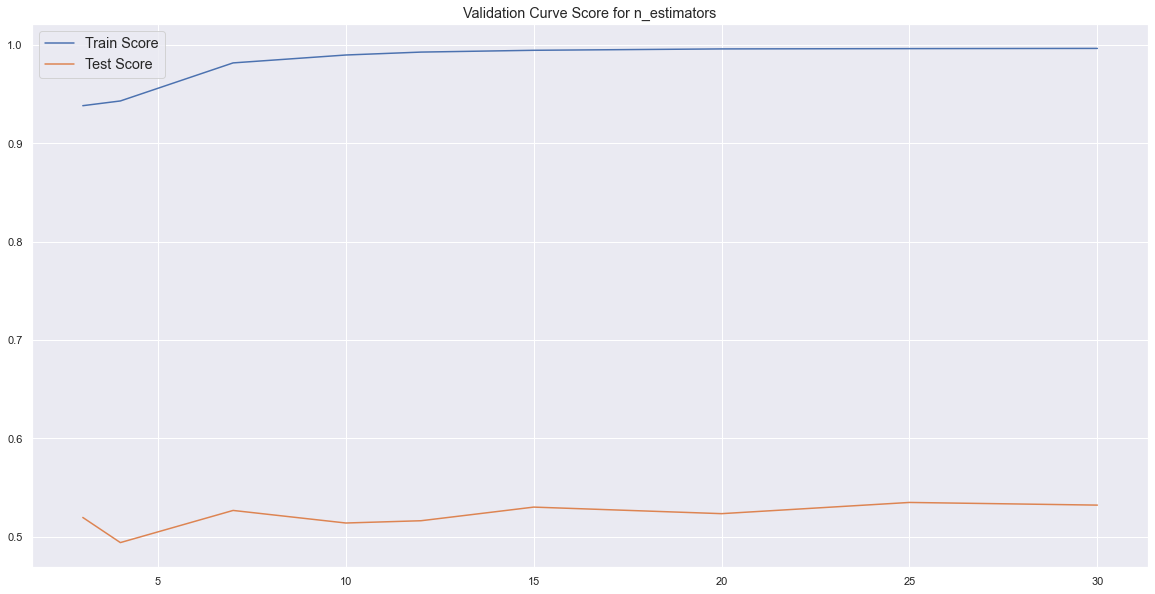

In [148]:
#Separate between X and Y
X_train = train_data.loc[:,Target_variables]

Y_train = train_data.loc[:,['Target_Direction']]

#Create validation curve for the Random Forest Classifier
rf = RandomForestClassifier()
train_scoreNum, test_scoreNum = validation_curve(rf,
                                X = X_train['2010-01-01':], y = Y_train.loc['2010-01-01':,'Target_Direction'], 
                                param_name = 'n_estimators', 
                                param_range = [3,4,7,10,12,15,20,25,30], cv = TimeSeriesSplit(n_splits = 3))

train_scores_mean = np.mean(train_scoreNum, axis=1)
train_scores_std = np.std(train_scoreNum, axis=1)
test_scores_mean = np.mean(test_scoreNum, axis=1)
test_scores_std = np.std(test_scoreNum, axis=1)

plt.figure(figsize = (20,10))
plt.plot([3,4,7,10,12,15,20,25,30],train_scores_mean)
plt.plot([3,4,7,10,12,15,20,25,30],test_scores_mean)
plt.legend(['Train Score','Test Score'], fontsize = 'large')
plt.title('Validation Curve Score for n_estimators', fontsize = 'large')

In [149]:
def generate_rfc(sector_name):
    print(f'The current cluster running is: {sector_name}')
    sector_data = rfc_data[rfc_data['Sector'] == sector_name].copy()
    sector_train = sector_data[:'2019-12-31']
    sector_train = sector_train.dropna().copy()
    
    X_train = sector_train.loc[:,Target_variables]
    features = X_train.columns

    Y_train = sector_train.loc[:,['Target_Direction']]
    
    params = {'max_depth': [5, 7],
          'max_features': ['sqrt'],
          'min_samples_leaf': [10, 15, 20],
          'n_estimators': [5, 7, 9],
          'min_samples_split':[20, 25, 30]}
    
    rf = RandomForestClassifier()
    time_series_split = TimeSeriesSplit(n_splits = 3)
    
    rf_cv = GridSearchCV(rf, params, cv = time_series_split, n_jobs = -1, verbose = 10)
    
    rf_cv.fit(X_train, Y_train.values.ravel())
    
    importances = rf_cv.best_estimator_.feature_importances_
    indices = np.argsort(importances)
    plt.figure(1)
    plt.title(f'{sector_name} Feature Importances - Alpha Vantage')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Relative Importance')
    plt.savefig(f'{os.getcwd()}\\RFC_Images\\{sector_name}_RelativeImportanceAV')
    
    file_loc = f'{os.getcwd()}\\RFC_Pickles\\Sector_{sector_dict[sector_name]}'
    pickle.dump(rf_cv, open(file_loc, 'wb'))

The current cluster running is: Technology
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 156 out of 162 | elapsed:    9.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   10.3s finished


Generated RFC - Technology
The current cluster running is: Healthcare
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 156 out of 162 | elapsed:    9.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   10.1s finished


Generated RFC - Healthcare
The current cluster running is: Financial Services
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 156 out of 162 | elapsed:   12.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   13.1s finished


Generated RFC - Financial Services
The current cluster running is: Real Estate
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0510s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 156 out of 162 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    1.9s finished


Generated RFC - Real Estate
The current cluster running is: Consumer Cyclical
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1477s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0707s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 139 out of 162 | elapsed:    5.8s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done 156 out of 162 | elapsed:    6.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    6.7s finished


Generated RFC - Consumer Cyclical
The current cluster running is: Industrials
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 156 out of 162 | elapsed:    9.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    9.6s finished


Generated RFC - Industrials
The current cluster running is: Communication Services
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1329s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 139 out of 162 | elapsed:    4.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 156 out of 162 | elapsed:    5.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    5.7s finished


Generated RFC - Communication Services
The current cluster running is: Consumer Defensive
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1721s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0270s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 156 out of 162 | elapsed:    8.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    8.4s finished


Generated RFC - Consumer Defensive
The current cluster running is: Energy
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0790s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 156 out of 162 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    2.7s finished


Generated RFC - Energy
The current cluster running is: Basic Materials
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0700s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 156 out of 162 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    1.8s finished


Generated RFC - Basic Materials
The current cluster running is: Utilities
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1030s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 156 out of 162 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    3.5s finished


Generated RFC - Utilities
The current cluster running is: Misc
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0420s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1590s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 156 out of 162 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    1.1s finished


Generated RFC - Misc


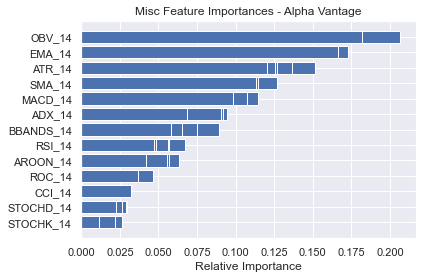

In [150]:
for sector in sectors:
    generate_rfc(sector)
    print('Generated RFC - ' + sector)

In [151]:
# Test dates list 

test_dates = []
for timestamp in list(test_data.index.unique()):
    test_dates.append(timestamp.strftime('%Y-%m-%d'))

In [152]:
test_data

,High,Low,Open,Close,Volume,Adj Close,Symbol,Sector,Close_Future_13,Target,...,STOCHK_14,STOCHD_14,RSI_14,ADX_14,CCI_14,AROON_14,BBANDS_14,OBV_14,ATR_14,ROC_14
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,75.150002,73.797501,74.059998,75.087502,135480400.0,73.931435,AAPL,Technology,79.425003,7.430597,...,87.3653,84.9029,68.6367,37.9856,150.5368,92.8571,70.3491,1.580662e+09,1.1322,8.8680
2020-01-03,75.144997,74.125000,74.287498,74.357498,146322800.0,73.212669,AAPL,Technology,79.807503,8.346094,...,87.3653,84.9029,68.6367,37.9856,132.7867,92.8571,70.8081,1.580662e+09,1.1234,8.8680
2020-01-06,74.989998,73.187500,73.447502,74.949997,118387200.0,73.796051,AAPL,Technology,79.577499,3.038292,...,87.3653,84.9029,68.6367,37.9856,107.7407,85.7143,71.2439,1.580662e+09,1.1706,8.8680
2020-01-07,75.224998,74.370003,74.959999,74.597504,108872000.0,73.448982,AAPL,Technology,77.237503,6.908736,...,84.0437,84.9029,68.6367,37.9856,105.7831,92.8571,71.5715,1.580662e+09,1.1475,6.6212
2020-01-08,76.110001,74.290001,74.290001,75.797501,132079200.0,74.630501,AAPL,Technology,79.422501,5.565684,...,87.3498,84.9029,68.6367,37.9856,114.8039,78.5714,71.9741,1.580662e+09,1.1942,8.1238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-05,57.320000,56.139999,57.299999,56.500000,23264800.0,56.500000,XOM,Energy,55.270000,-2.234343,...,51.1422,59.0805,50.2638,20.7530,-25.1294,-42.8571,56.9250,-2.605772e+08,1.6045,-6.4415
2021-04-06,57.540001,56.259998,56.840000,56.340000,18926300.0,56.340000,XOM,Energy,55.570000,-1.259087,...,48.1342,53.6185,49.6411,19.3214,-7.9806,-28.5714,56.7271,-2.605772e+08,1.5813,-4.6862
2021-04-07,56.770000,56.240002,56.389999,56.590000,22385000.0,56.590000,XOM,Energy,55.680000,0.858215,...,37.0315,45.4360,50.6695,18.0063,-9.3276,-28.5714,56.5286,-2.605772e+08,1.5062,-4.6825


In [153]:
pred = pd.DataFrame({'Date':[], 'Company':[], 'Prediction':[]})
for date in test_dates:
    day_data = test_data.loc[date]
    
    for idx, row in day_data.reset_index().iterrows():
        rf_cv = pickle.load(open(os.getcwd() + f'\\RFC_Pickles\\Sector_{sector_dict[row.Sector]}', 'rb'))
        best_rf = rf_cv.best_estimator_
        X_test = row.loc[Target_variables]
        pred = pred.append(pd.DataFrame({'Date':[row.Date], 'Company':[row.Symbol],
                                                'Prediction':best_rf.predict_proba([X_test])[:,1]}), ignore_index = True)

In [154]:
pred

,Date,Company,Prediction
0,2020-01-02,AAPL,0.584383
1,2020-01-02,ABBV,0.530704
2,2020-01-02,ABT,0.515935
3,2020-01-02,ACN,0.475398
4,2020-01-02,ADBE,0.502821
...,...,...,...
32315,2021-04-09,VZ,0.655845
32316,2021-04-09,WBA,0.541247
32317,2021-04-09,WFC,0.541049
32318,2021-04-09,WMT,0.544332


In [155]:
pred['Predicted_Dir'] = np.where(pred['Prediction']>=0.505,1,0)
pred

,Date,Company,Prediction,Predicted_Dir
0,2020-01-02,AAPL,0.584383,1
1,2020-01-02,ABBV,0.530704,1
2,2020-01-02,ABT,0.515935,1
3,2020-01-02,ACN,0.475398,0
4,2020-01-02,ADBE,0.502821,0
...,...,...,...,...
32315,2021-04-09,VZ,0.655845,1
32316,2021-04-09,WBA,0.541247,1
32317,2021-04-09,WFC,0.541049,1
32318,2021-04-09,WMT,0.544332,1


In [156]:
pred.sort_values(by=['Company', 'Date'], inplace=True)
pred.set_index(['Date', 'Company'])

,,Prediction,Predicted_Dir
Date,Company,,
2020-01-02,AAPL,0.584383,1
2020-01-03,AAPL,0.584383,1
2020-01-06,AAPL,0.584383,1
2020-01-07,AAPL,0.584383,1
2020-01-08,AAPL,0.584383,1
...,...,...,...
2021-04-05,XOM,0.572645,1
2021-04-06,XOM,0.473401,0
2021-04-07,XOM,0.493480,0


In [157]:
target_data = test_data.reset_index()[['Date', 'Symbol', 'Target_Direction', 'Target']].copy()
target_data.columns = ['Date', 'Company', 'Actual', 'Pct_Change']
target_data.set_index(['Date', 'Company'], inplace=True)

In [158]:
accuracy_pred = pd.concat([pred.set_index(['Date', 'Company']), target_data], axis=1)
accuracy_pred

,,Prediction,Predicted_Dir,Actual,Pct_Change
Date,Company,,,,
2020-01-02,AAPL,0.584383,1,1,7.430597
2020-01-03,AAPL,0.584383,1,1,8.346094
2020-01-06,AAPL,0.584383,1,1,3.038292
2020-01-07,AAPL,0.584383,1,1,6.908736
2020-01-08,AAPL,0.584383,1,1,5.565684
...,...,...,...,...,...
2021-04-05,XOM,0.572645,1,0,-2.234343
2021-04-06,XOM,0.473401,0,0,-1.259087
2021-04-07,XOM,0.493480,0,1,0.858215


In [159]:
y_pred = accuracy_pred['Predicted_Dir']
y_test = accuracy_pred['Actual']
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.11      0.17     13372
           1       0.59      0.89      0.71     18948

    accuracy                           0.57     32320
   macro avg       0.50      0.50      0.44     32320
weighted avg       0.51      0.57      0.49     32320

0.5659962871287129


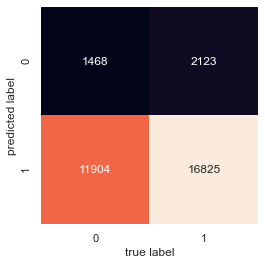

In [160]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [161]:
filtered_dates = []
for i in range(len(test_dates)):
    if i % 13 == 0:
        filtered_dates.append(test_dates[i])
filtered_dates

['2020-01-02',
 '2020-01-22',
 '2020-02-10',
 '2020-02-28',
 '2020-03-18',
 '2020-04-06',
 '2020-04-24',
 '2020-05-13',
 '2020-06-02',
 '2020-06-19',
 '2020-07-09',
 '2020-07-28',
 '2020-08-14',
 '2020-09-02',
 '2020-09-22',
 '2020-10-09',
 '2020-10-28',
 '2020-11-16',
 '2020-12-04',
 '2020-12-23',
 '2021-01-13',
 '2021-02-02',
 '2021-02-22',
 '2021-03-11',
 '2021-03-30']

In [162]:
filtered_pred = accuracy_pred.copy()
filtered_pred.reset_index(inplace=True)

In [163]:
filtered_pred = filtered_pred[filtered_pred['Date'].isin(filtered_dates)]
filtered_pred

,Date,Company,Prediction,Predicted_Dir,Actual,Pct_Change
0,2020-01-02,AAPL,0.584383,1,1,7.430597
13,2020-01-22,AAPL,0.533677,1,1,0.531571
26,2020-02-10,AAPL,0.513312,1,0,-7.660695
39,2020-02-28,AAPL,0.509306,1,0,-13.284682
52,2020-03-18,AAPL,0.648703,1,1,4.866807
...,...,...,...,...,...,...
32260,2021-01-13,XOM,0.568800,1,0,-2.226808
32273,2021-02-02,XOM,0.625316,1,1,20.644308
32286,2021-02-22,XOM,0.667302,1,1,12.713717
32299,2021-03-11,XOM,0.571625,1,0,-9.293253


In [164]:
y_pred_filt = filtered_pred['Predicted_Dir']
y_test_filt = filtered_pred['Actual']
print(classification_report(y_test_filt,y_pred_filt))
print(accuracy_score(y_test_filt, y_pred_filt))

              precision    recall  f1-score   support

           0       0.44      0.11      0.18      1092
           1       0.57      0.89      0.69      1433

    accuracy                           0.55      2525
   macro avg       0.50      0.50      0.44      2525
weighted avg       0.51      0.55      0.47      2525

0.5536633663366337


In [165]:
# top_10_pred = pd.DataFrame({'Date':[], 'Company':[], 'Prediction':[], 'Actual':[], 'Pct_Change':[]})
top_10_pred = []
for date in test_dates:
    day_pred = pd.DataFrame({'Date':[], 'Company':[], 'Prediction':[]})
    day_data = test_data.loc[date]
    
    for sector_name in sectors:
        rf_cv =  pickle.load(open(os.getcwd() + f'\\RFC_Pickles\\Sector_{sector_dict[sector_name]}', 'rb'))
        best_rf = rf_cv.best_estimator_
        sector_data = day_data.loc[day_data['Sector'] == sector_name].copy()
        sector_data = sector_data.dropna()
        if (sector_data.shape[0]>0):
            X_test = sector_data.loc[:,Target_variables]
            day_pred = day_pred.append(pd.DataFrame({'Date':sector_data.index,
                                                                       'Company':sector_data['Symbol'],
                                                                       'Prediction':best_rf.predict_proba(X_test)[:,1]}), ignore_index = True)
        
    top_10 = day_pred.sort_values(by = ['Prediction'], ascending = False).head(10)

    for selected_company in top_10['Company']:
        actual = rfc_data[rfc_data.Symbol == selected_company].loc[date,'Target_Direction']
        pct_change = rfc_data[rfc_data.Symbol == selected_company].loc[date,'Target']
        top_10.loc[top_10.Company == selected_company,'Actual'] = actual
        top_10.loc[top_10.Company == selected_company,'Pct_Change'] = pct_change
    top_10_pred.append(top_10)
top_10_pred = pd.concat(top_10_pred)
top_10_pred

,Date,Company,Prediction,Actual,Pct_Change
11,2020-01-02,QCOM,0.694129,1.0,5.432040
99,2020-01-02,SO,0.672507,1.0,10.283065
46,2020-01-02,AMT,0.672003,1.0,4.513097
98,2020-01-02,NEE,0.665460,1.0,8.988803
47,2020-01-02,SPG,0.652839,1.0,2.051429
...,...,...,...,...,...
77,2021-04-09,TMUS,0.622582,1.0,4.296045
3,2021-04-09,AVGO,0.622182,0.0,-3.245281
75,2021-04-09,NFLX,0.619294,0.0,-7.630884
44,2021-04-09,V,0.618907,1.0,7.546311


In [166]:
top_10_pred['Predicted_Dir'] = np.where(top_10_pred['Prediction']>=0.505,1,0)
top_10_pred

,Date,Company,Prediction,Actual,Pct_Change,Predicted_Dir
11,2020-01-02,QCOM,0.694129,1.0,5.432040,1
99,2020-01-02,SO,0.672507,1.0,10.283065,1
46,2020-01-02,AMT,0.672003,1.0,4.513097,1
98,2020-01-02,NEE,0.665460,1.0,8.988803,1
47,2020-01-02,SPG,0.652839,1.0,2.051429,1
...,...,...,...,...,...,...
77,2021-04-09,TMUS,0.622582,1.0,4.296045,1
3,2021-04-09,AVGO,0.622182,0.0,-3.245281,1
75,2021-04-09,NFLX,0.619294,0.0,-7.630884,1
44,2021-04-09,V,0.618907,1.0,7.546311,1


In [170]:
top_10_pred.head(10)

,Date,Company,Prediction,Actual,Pct_Change,Predicted_Dir
11,2020-01-02,QCOM,0.694129,1.0,5.432040,1
99,2020-01-02,SO,0.672507,1.0,10.283065,1
46,2020-01-02,AMT,0.672003,1.0,4.513097,1
98,2020-01-02,NEE,0.665460,1.0,8.988803,1
47,2020-01-02,SPG,0.652839,1.0,2.051429,1
54,2020-01-02,MCD,0.645098,1.0,7.036461,1
96,2020-01-02,DUK,0.644621,1.0,6.483429,1
44,2020-01-02,V,0.637195,1.0,9.612016,1
86,2020-01-02,PG,0.635477,1.0,2.316629,1
75,2020-01-02,NFLX,0.634021,1.0,6.983294,1


In [167]:
y_pred_top10 = top_10_pred['Predicted_Dir']
y_test_top10 = top_10_pred['Actual']
print(classification_report(y_test_top10,y_pred_top10))
print(accuracy_score(y_test_top10, y_pred_top10))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1304
         1.0       0.59      1.00      0.74      1896

    accuracy                           0.59      3200
   macro avg       0.30      0.50      0.37      3200
weighted avg       0.35      0.59      0.44      3200

0.5925


C:\Users\prane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
